## Input a given Network


In [125]:
import numpy as np
import sys
    
# Test Graph 2 ( A crazy network )
N=6;
A= np.zeros((N,N));
Key_rate= np.zeros((N,N));  #Expected Key Arrival Rate
C_tilde = np.zeros((N,N));

A[0][1]=1;
A[0][2]=1;
A[1][3]=1;
A[1][4]=1;
A[2][3]=1;
A[3][4]=1;
A[4][5]=1;
A[3][5]=1;

Key_rate[0][1]=0.5;
Key_rate[0][2]=0.5;
Key_rate[1][3]=0.6;
Key_rate[1][4]=0.7;
Key_rate[2][3]=0.4;
Key_rate[3][4]=0.5;
Key_rate[4][5]=0.3;
Key_rate[3][5]=0.7;

start = 0; dest = 5
n = N   #Number of Nodes
T = 100 #Number of time slots of running

m = 0  #Counting number of edges
E = [] #Storing as adjacency list of edges

#Constructing Adjacency list and C_tilde matrix for capacity
for i in range(N):
    for j in range(N):
        if(A[i][j]!=0):
            m = m+1
            E.append([i,j,A[i][j],Key_rate[i][j]])
        C_tilde[i][j] = min(A[i][j],Key_rate[i][j])

## Finding Min-Cut using Ford Fulkerson Algorithm

Ford Fulkerson can be used to find the max-flow in the graph. We will fix our capacity region $\lambda$ at 95% of the estimated upper bound, which is given as the min cut of graph where edge capacities $\tilde{c}_e = min(c_e,\eta_e)$

In [127]:
def BFS(graph,s, t, parent): 

    # Mark all the vertices as not visited 
    visited =[False]*(m) 

    # Create a queue for BFS 
    queue=[] 

    # Mark the source node as visited and enqueue it 
    queue.append(s) 
    visited[s] = True

     # Standard BFS Loop 
    while queue: 

        #Dequeue a vertex from queue and print it 
        u = queue.pop(0) 

        # Get all adjacent vertices of the dequeued vertex u 
        for ind, val in enumerate(graph[u]): 
            if visited[ind] == False and val > 0 : 
                queue.append(ind) 
                visited[ind] = True
                parent[ind] = u 

    # If we reached sink in BFS starting from source, then return 
    # true, else false 
    return True if visited[t] else False


def FordFulkerson(graph, source, sink): 

    # This array is filled by BFS and to store path 
    parent = [-1]*(m) 

    max_flow = 0 # There is no flow initially 

    # Augment the flow while there is path from source to sink 
    while BFS(graph, source, sink, parent) : 

        # Find minimum residual capacity of the edges along the 
        # path filled by BFS. Or we can say find the maximum flow 
        # through the path found. 
        path_flow = float("Inf") 
        s = sink 
        while(s !=  source): 
            path_flow = min (path_flow, graph[parent[s]][s]) 
            s = parent[s] 

        # Add path flow to overall flow 
        max_flow +=  path_flow 

        # update residual capacities of the edges and reverse edges 
        # along the path 
        v = sink 
        while(v !=  source): 
            u = parent[v] 
            graph[u][v] -= path_flow 
            graph[v][u] += path_flow 
            v = parent[v] 

    return max_flow 

lamb = FordFulkerson(C_tilde, start, dest)  #Working at 95% of capacity

## Finding minima path
We use dijikstra's algorithm on a graph with edge weights given by $\tilde{Q}_e(t) - k\tilde{S}_e(t)$

In [129]:
def minDistance(dist, sptSet): 

    # Initilaize 
    min = sys.maxsize 

    # Search not nearest vertex not in the shortest path tree 
    for v in range(n): 
        if (dist[v] < min and sptSet[v] == False): 
            min = dist[v] 
            min_index = v
    return min_index 

def dijkstra(graph, src, sink): 
  
    dist = [sys.maxsize]*n
    dist[src] = 0
    sptSet = [False]*n
    route = [None]*n
    last_node = [None]*n

    for cout in range(n): 
        
        u = minDistance(dist, sptSet) 
        if(u==src):
            route[u] = [u]
        else:
            route[u] = route[last_node[u]]+[u]
        sptSet[u] = True

        for v in range(n): 
            if (A[u][v]!= 0 and sptSet[v] == False and dist[v] > (dist[u] + graph[u][v])):
                dist[v] = dist[u] + graph[u][v]
                last_node[v]= u
    return route


In [131]:
class packet:
    def __init__(self,i,t, r, d):
        self.index = i
        self.time = t
        self.route = r
        self.dist = d
        
from collections import deque

class Queue():  #A FIFO queue

    def __init__(self, max_size = sys.maxsize):
        self._queue = deque(maxlen=max_size)
        self.size = 0
        
    def isEmpty(self):
        return self.size == 0

    def enqueue(self, item):
        self._queue.append(item)
        self.size += 1

    def dequeue(self):
        if ():
            return self._queue.pop()
            self.size -= 1
        else:
            return (-1)

In [130]:
def route_edge_set(route):
    route_edge = []
    for j in range (len(route)-1):
        for i in range(m):
            if(E[i][0]==route[j] and E[i][1]==route[j+1]):
                route_edge.append(i)
    return route_edge

In [142]:
Q = np.zeros(m)
Q_sum = np.zeros(T)
S = np.zeros(m)
S_v = np.zeros(m)

# The Weight-vector would be simply the Q-vector
W=np.zeros((n, n))

# Vaiables for recording the statistics 
sum_Q_len=0
avg_Q_len= np.zeros((1,T))

# Number of current packet entered into the network
Packet_index=0

# These variables keep track of tree usages
# Initialize the global tree-base with the "zero-tree"

Tree_base=np.zeros((n-1,2,1));

#Number of trees =1
Num_tree=1;

# Usage vector keeps count of number of packets entering into the trees
Usage=np.zeros((1,1));

Phy_Q = []
for i in range(n):
    obj = Queue()
    Phy_Q.append(obj)

k = 1 #The constant of proportion between virtual queues and key queues

for t in range(T):
    a=np.random.poisson(lamb)        # Arrival to the source 
    #sum_arr=sum_arr+a
    
    for i in range(a):
        Phy_Q[0].enqueue([0,t,route_edge,0])
        
    #Assuming Poisson Key Generation Process
    for i in range(m):
        K = np.random.poisson(E[i][3])
        S[i] = S[i] + K
        S_v[i] = S_v[i] + K
    
    #Setting the weight of our graph whose min path is to be computed
    # as the difference of virtual queues and virtual key queues
    G = np.zeros((n,n))
    for i in range(m):
        G[E[i][0]][E[i][1]] = Q[i]- k*S_v[i]
    
    #Assigning optimal route through dijktras algo(Unicast)
    routes = dijkstra(G,start,dest)
    
    #Converting route as sequence of nodes to sequence of edges
    route_edge = route_edge_set(routes[dest])
    
    # Virtual Queue Updation - Arrival
    for i in range(len(route_edge)):
        Q[route_edge[i]] = Q[route_edge[i]]+a
        S_v[i] = S_v[i] - a
    
    p = [0,t,route_edge,0]
    for j in range(a):
            Phy_Q[0].enqueue(p)  
            
    # Physical Queue Updation
   
    for i in range(n):
        obj = Phy_Q[i].dequeue()  #Assuming service process is limited to 1 packet per slot
        if(obj!=-1):
            next_edge = obj[2][obj[3]]
            next_node = E[next_edge][1] #Getting next node of packet in the route
            #Updating distance
            if (next_node!= dest):
                Phy_Q[next_node].enqueue(obj)
                obj[3] = obj[3]+1
            Q[next_edge] = Q[next_edge]-1 #Updating Virtual Queues
    
    for i in range(m): 
        Q_sum[t] = Q_sum[t] + Q[i]
        
    Q_sum[t] = Q_sum[t]/m
    print(a, Q[0])

2 0.0
0 0.0
2 2.0
1 3.0
0 3.0
0 3.0
0 3.0
0 3.0
1 4.0
1 4.0
0 4.0
0 4.0
2 4.0
3 4.0
1 5.0
0 5.0
2 7.0
0 7.0
0 7.0
1 8.0
0 8.0
3 11.0
0 11.0
2 11.0
4 15.0
0 15.0
2 15.0
0 15.0
1 16.0
0 16.0
0 16.0
1 16.0
1 17.0
0 17.0
0 17.0
0 17.0
0 17.0
1 17.0
0 17.0
2 17.0
1 17.0
3 17.0
0 17.0
0 17.0
2 19.0
0 19.0
1 19.0
1 20.0
0 20.0
0 20.0
2 22.0
1 22.0
2 22.0
0 22.0
0 22.0
0 22.0
1 23.0
0 23.0
1 24.0
1 25.0
1 26.0
0 26.0
0 26.0
0 26.0
2 28.0
0 28.0
2 30.0
0 30.0
2 32.0
1 32.0
1 33.0
0 33.0
0 33.0
0 33.0
0 33.0
0 33.0
0 33.0
1 33.0
1 33.0
0 33.0
1 33.0
0 33.0
0 33.0
0 33.0
3 33.0
0 33.0
0 33.0
0 33.0
3 33.0
0 33.0
1 34.0
1 35.0
0 35.0
1 36.0
0 36.0
0 36.0
1 37.0
0 37.0
1 38.0
1 39.0


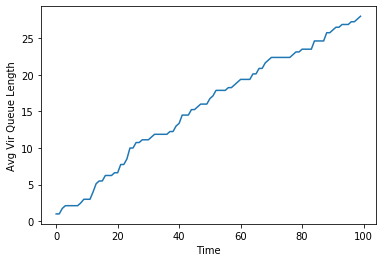

In [144]:
import matplotlib.pyplot as plt
plt.plot(Q_sum)
plt.xlabel("Time")
plt.ylabel("Avg Vir Queue Length")
plt.show()

In [96]:
route_edge

[1, 4, 6]